### *Modeling a Dynamic System of Coupled Neurons (Van der Pol oscillator Model)*
#### *@author: Kevin Costa Scaccia*
#### RA: 120.478

## Imports

In [0]:
import numpy as np  # math
import matplotlib.pyplot as plt  # plot
import time  # time spent
import networkx as nx  # plot graph

## Neuron Class

In [0]:
class Neuron:
    neuron_id = 0  # Neuron Class identifier counter
    active_value = 0.2  # output of an active neuron
    inactive_value = -0.02  # output of an inactive neuron
    # constructor
    def __init__(self, x, y):
        self.I = Neuron.active_value  
        self.p = 0.5
        self.x = x  # initial x  
        self.y = y  # initial y
        self.e = 0.02
        self.a = 6.0  # model parameter
        self.b = 0.1  # model parameter
        self.theta = 0.5 # activation limiar
        self.data_x = []  # x variation
        self.data_y = []  # y variation
        self.adjacency_list = []  # adjacent neurons list
        self.id = Neuron.neuron_id # unique identifier 
        Neuron.neuron_id += 1  # increment counter
        
    #
    # Check if a neuron is adjacent
    #
    def is_connected_to(self, neuron):
        for connected in self.adjacency_list:
            if connected['neuron'] == neuron:
                return True  # connected neuron
        return False  # don't connected
    
    #
    # Activation function (Heaviside)
    #
    def heaviside(v):
        if v >= 0:
            return Neuron.active_value
        else:
            return Neuron.inactive_value
    #
    # Calc x value
    #    
    def calc_x(self,):  # Van der Pol Neuron Model
        x = 3*self.x - self.x**3 + 2 - self.y + self.I + self.p  # dxdt
        # sum coupled neurons
        x = x + self.calc_S()
        return x
    
    #
    # Calc y value
    # 
    def calc_y(self,):  # Van der Pol Neuron Model
        y = self.e * (self.a*(1 + np.tanh(self.x/self.b)) - self.y )# dydt   
        return y
    
    #
    # Calc x value
    # 
    def iterate(self, h):
        self.data_x.append(self.x)
        self.data_y.append(self.y)
        self.x = self.x + h * self.calc_x()
        self.y = self.y + h * self.calc_y()
        
    #
    # Append a neuron in adjacency list (couple)
    #
    def couple(self, neuron, weight):
        self.adjacency_list.append({'neuron': neuron, 'weight': weight})
        
    #
    # Interation 
    #
    def calc_S(self,):
        summation = 0.0
        for neuron in self.adjacency_list:
            summation += neuron['weight'] * Neuron.heaviside(neuron['neuron'].x - self.theta)
        return summation

 ## Neural Network Class

In [0]:
##### Constructor parameters: 
#  n_neurons: number of neurons in the network
#          K: number of coupled neurons to each neuron
#   coupling: coupling force
#   topology: random, regular or free_scale
class NeuralNetwork():
    # Constructor 
    def __init__(self, n_neurons, K, coupling, topology='random'):
        self.n_neurons = n_neurons
        self.K = K
        self.coupling = coupling 
        self.neurons = []
        self.data_t = [] # time progress
        self.topology = topology  # graph topology
        if K >= n_neurons or coupling < 0:
            raise Exception("Invalid parameters")
        
    #
    # Init neurons and connections given the topology
    #
    def init(self,):
        # init neurons
        self.neurons = []
        for i in range(self.n_neurons):  # initialize neurons
            neuron = Neuron(x=np.random.rand()*4 -2, y=np.random.rand()*4)
            self.neurons.append(neuron)  # append to neurons list
        print(">> {} Neurons initialized".format( self.n_neurons ))
        print(">> Coupling: {}  |  K: {}".format( self.coupling, self.K ))
        
        # switch topology(connections)
        if self.topology == 'regular':
            print(">> Regular Topology")
            self.init_regular_topology()
        elif self.topology == 'free_scale':
            print(">> Free Scale Topology")
            self.init_free_scale_topology()
        else:
            print(">> Random Topology")
            self.init_random_topology()
            
    #
    # Regular Topology
    #
    def init_regular_topology(self,):        
        # Coupling
        for i in range(self.n_neurons):
            # each neuron has k couplings
            for k in range(self.K):  # same for each neuron (regular topology)
                # prevents multiple couplings to the same neuron 
                # prevents self-coupling
                j = np.random.randint(self.n_neurons)
                while self.neurons[i].is_connected_to(self.neurons[j]) or i == j:                     
                    j = np.random.randint(self.n_neurons)  # generates a different neuron than the current
                # do the coupling
                self.neurons[i].couple( self.neurons[j], self.coupling )
        print(">> {} Regular couplings in the Graph".format( self.n_neurons*self.K ))      
    
    #
    # Random Topology 
    #
    def init_random_topology(self,):        
        # Coupling
        for i in range(self.n_neurons):  # for each neuron
            # random number of connections
            for k in range( np.random.randint(0, self.K)): 
                # prevents multiple couplings to the same neuron 
                # prevents self-coupling
                j = np.random.randint(self.n_neurons)
                while self.neurons[i].is_connected_to(self.neurons[j]) or i == j:                     
                    j = np.random.randint(self.n_neurons)  # generates a different neuron than the current
                # do the coupling
                self.neurons[i].couple( self.neurons[j], self.coupling )
        print(">> {} Random couplings in the Graph".format( self.n_neurons*self.K ))      
        
    #
    # Free Scale Topology (Barabási–Albert)
    #
    def init_free_scale_topology(self,):   
        total_conn = 0  # total of graph connections
        divider_index = int(self.n_neurons*0.1)
        conn_count = np.zeros(self.n_neurons)
        
        # Connect randomly 10% of the neurons (init network)
        for i in range(divider_index):
            for k in range(self.K):  # each neuron has k couplings
                # prevents multiple couplings to the same neuron
                # prevents self-coupling
                j = np.random.randint(self.n_neurons)
                while self.neurons[i].is_connected_to(self.neurons[j] or i == j):
                    j = np.random.randint(self.n_neurons) # generates a different neuron 
                # do the coupling
                self.neurons[i].couple( self.neurons[j], self.coupling)
                # increment connections count
                conn_count[i] += 1 
                conn_count[j] += 1
                total_conn += 2
        print(">> {} Random couplings in the Graph".format( total_conn ))     

        # Do the remaining coupling
        for i in range(divider_index, self.n_neurons):  # for each remaining neuron
            # do the total connections needed for the neuron 
            while conn_count[i] < self.K:
                # get a random neuron
                rand_neuron = np.random.randint(0, self.n_neurons)
                # calculate its probability
                p_rand_neuron = conn_count[rand_neuron] / total_conn
                #print("probabil: ", p_rand_neuron)
                if p_rand_neuron >= np.random.rand():  # accept neuron
                    # prevents multiple couplings to the same neuron 
                    # prevents self-coupling
                    j = np.random.randint(self.n_neurons)
                    #print("Accepted!")
                    while self.neurons[i].is_connected_to(self.neurons[j]) or i == j:                     
                        j = np.random.randint(self.n_neurons)  # generates a different neuron than the current
                # do the coupling
                self.neurons[i].couple( self.neurons[j], self.coupling)
                # increment connections count
                conn_count[i] += 1 
                conn_count[j] += 1  
                total_conn += 2  # 1 edge = two connections
        print(">> {} Probability couplings in the Graph".format( total_conn ))      
        
    #
    # Run simulation
    #
    def simulate(self, iterations, h):
        time_start = time.time()  # get current time
        self.init()
        self.data_t = range(0, iterations)
        #np.random.seed(0)  #         
        for i in self.data_t:
            for neuron in self.neurons:  # update each neuron
                neuron.iterate(h)
            # print progress
            if i*10 % len(self.data_t) == 0:
                print("{}% ".format( i/len(self.data_t)*100), end='')

        print("\n>> Successfully iterated neurons")
        print(">> Time spent: {:2.4}s".format(time.time() - time_start))
        
    #
    # Plot Pulse
    #
    def plot_pulse(self,):
        plt.figure(num=None, figsize=(14, 4), dpi=80, facecolor='w')
        plt.grid(color='black', linestyle='-', linewidth=0.2)
        for neuron in self.neurons:
            plt.plot(self.data_t, neuron.data_x, linestyle='-')
        plt.show()
    
    #
    # Plot Graph
    #
    def plot_graph(self, limit_nodes=200):
        neurons = self.neurons
        G = nx.Graph()
        for neuron in neurons: # add nodes
            G.add_node(neuron.id)   
        if len(neurons) >= limit_nodes: # add edges
            neurons = neurons[:limit_nodes]
        for neuron in neurons:
            for adj in neuron.adjacency_list:
                G.add_edge(neuron.id, adj['neuron'].id)
        # plot itself
        fig = plt.figure(1, figsize=(12, 8))  # figure size
        pos=nx.fruchterman_reingold_layout(G)  # layout algorithm
        plt.axis('off')  # no boarder 
        nx.draw_networkx_nodes(G,pos,node_size=50)  # plot nodes
        nx.draw_networkx_edges(G,pos,alpha=0.4)  # plot ties
        fig.set_facecolor('#cccccc')  # graph background color
        plt.title('Neurons Graph', size=16)  # title
        plt.show() 

## Simulations

### Topology Examples

>> 500 Neurons initialized
>> Coupling: 0.1  |  K: 5
>> Free Scale Topology
>> 500 Random couplings in the Graph
>> 4520 Probability couplings in the Graph

>> Successfully iterated neurons
>> Time spent: 0.02533s


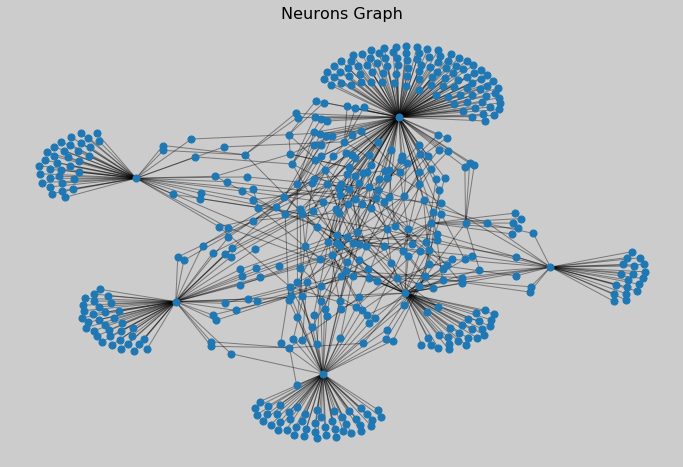

In [6]:
#@markdown ### Free Scale Topology
np.random.seed(7)
simA = NeuralNetwork(n_neurons=500, K=5, coupling=0.1, topology="free_scale")
simA.simulate(iterations=0, h=.1)
simA.plot_graph(limit_nodes=1000)

>> 100 Neurons initialized
>> Coupling: 0.1  |  K: 2
>> Regular Topology
>> 200 Regular couplings in the Graph

>> Successfully iterated neurons
>> Time spent: 0.00369s


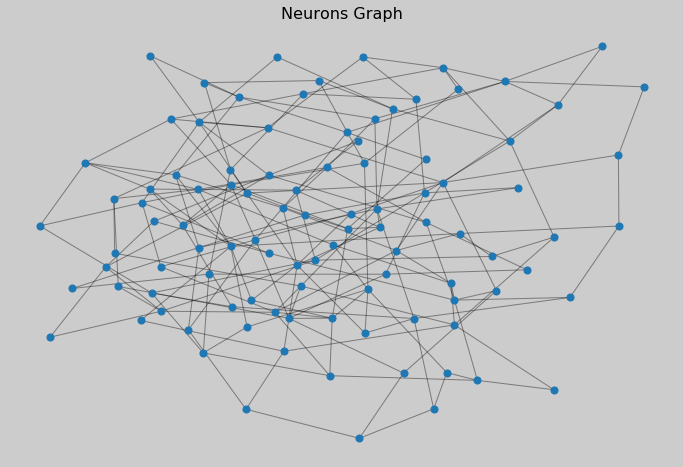

In [7]:
#@markdown ### Regular Topology
np.random.seed(7)
simA = NeuralNetwork(n_neurons=100, K=2, coupling=0.1, topology="regular")
simA.simulate(iterations=0, h=.1)
simA.plot_graph()

>> 20 Neurons initialized
>> Coupling: 0.1  |  K: 5
>> Random Topology
>> 100 Random couplings in the Graph
0.0% 
>> Successfully iterated neurons
>> Time spent: 0.001449s


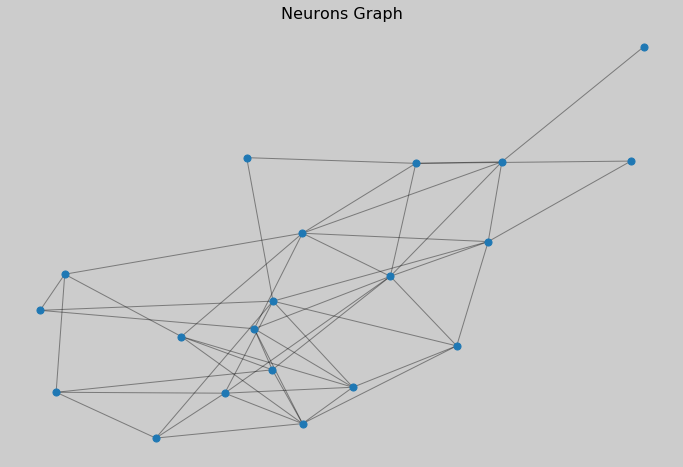

In [8]:
#@markdown ### Random Topology
np.random.seed(7)
simA = NeuralNetwork(n_neurons=20, K=5, coupling=0.1)
simA.simulate(iterations=1, h=.1)
simA.plot_graph(limit_nodes=1000)

## Full Simulations

>> 100 Neurons initialized
>> Coupling: 0.8  |  K: 2
>> Regular Topology
>> 200 Regular couplings in the Graph
0.0% 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 
>> Successfully iterated neurons
>> Time spent: 26.73s


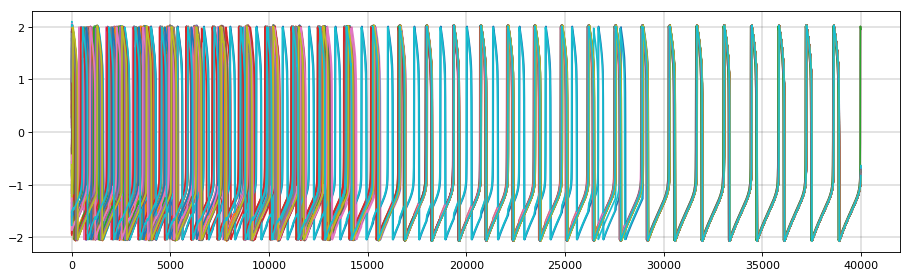

In [0]:
#@markdown ### Simulation 01
np.random.seed(0)
simD = NeuralNetwork(n_neurons=100, K=2, coupling=0.8, topology="regular")
simD.simulate(iterations=40000, h=0.1)
simD.plot_pulse()

>> 100 Neurons initialized
>> Coupling: 0.8  |  K: 10
>> Regular Topology
>> 1000 Regular couplings in the Graph
0.0% 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 
>> Successfully iterated neurons
>> Time spent: 49.67s


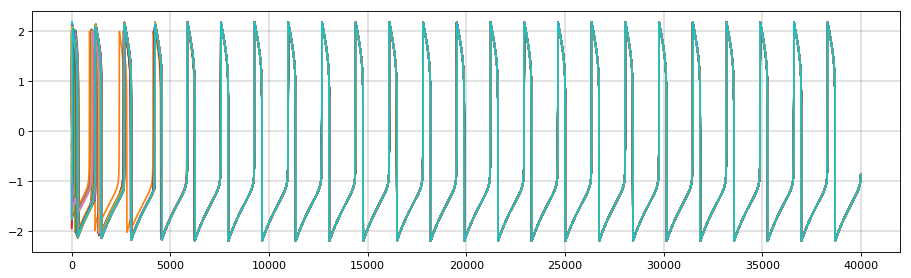

In [9]:
#@markdown ### Simulation 02
np.random.seed(0)
simD = NeuralNetwork(n_neurons=100, K=10, coupling=0.8, topology="regular")
simD.simulate(iterations=40000, h=0.1)
simD.plot_pulse()

>> 100 Neurons initialized
>> Coupling: 0.8  |  K: 10
>> Free Scale Topology
>> 200 Random couplings in the Graph
>> 1750 Probability couplings in the Graph
0.0% 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 
>> Successfully iterated neurons
>> Time spent: 45.09s


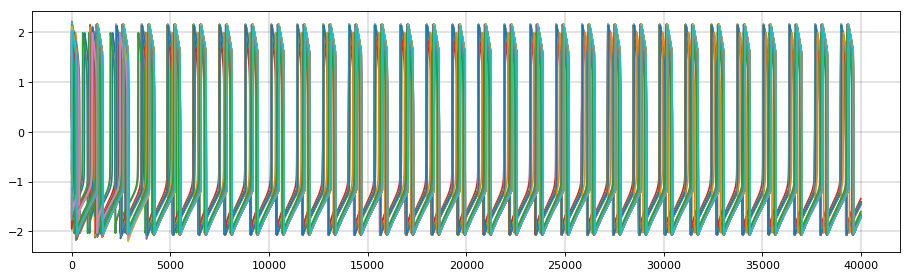

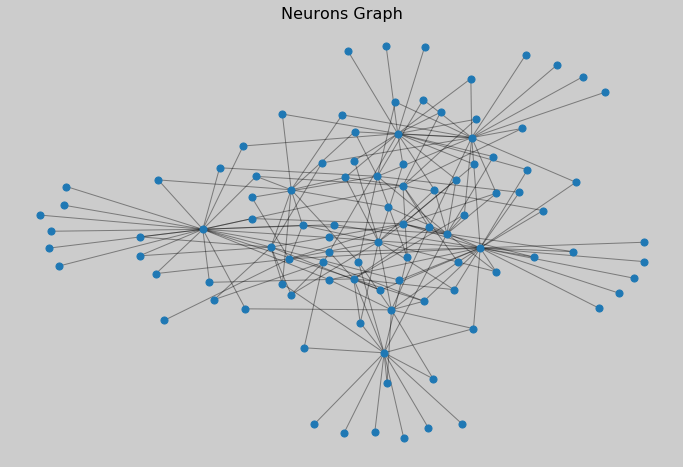

In [18]:
#@markdown ### Simulation 03
np.random.seed(0)
simD = NeuralNetwork(n_neurons=100, K=10, coupling=0.8, topology="free_scale")
simD.simulate(iterations=40000, h=0.1)
simD.plot_pulse()
simD.plot_graph()

>> 100 Neurons initialized
>> Coupling: 1.0  |  K: 2
>> Free Scale Topology
>> 40 Random couplings in the Graph
>> 354 Probability couplings in the Graph
0.0% 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 
>> Successfully iterated neurons
>> Time spent: 33.43s


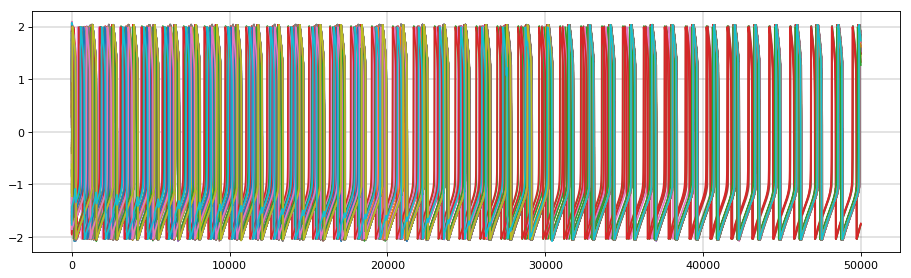

In [0]:
#@markdown ### Simulation 04
np.random.seed(0)
simD = NeuralNetwork(n_neurons=100, K=2, coupling=1.0, topology="free_scale")
simD.simulate(iterations=50000, h=0.1)
simD.plot_pulse()

>> 500 Neurons initialized
>> Coupling: 0.1  |  K: 2
>> Regular Topology
>> 1000 Regular couplings in the Graph
0.0% 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 
>> Successfully iterated neurons
>> Time spent: 178.9s


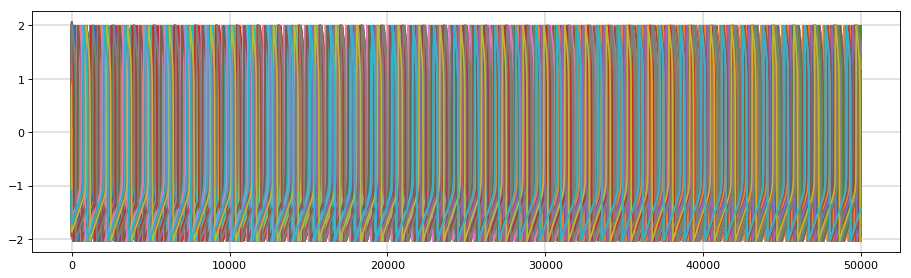

In [11]:
#@markdown ### Simulation 05
np.random.seed(0)
simD = NeuralNetwork(n_neurons=500, K=2, coupling=0.1, topology="regular")
simD.simulate(iterations=50000, h=0.1)
simD.plot_pulse()

>> 10 Neurons initialized
>> Coupling: 0.01  |  K: 8
>> Random Topology
>> 80 Random couplings in the Graph
0.0% 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 
>> Successfully iterated neurons
>> Time spent: 3.189s


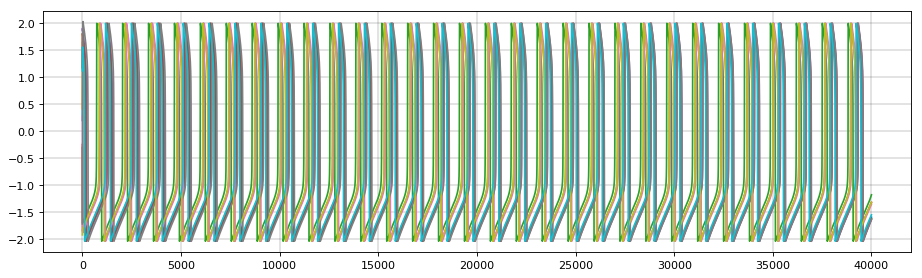

In [24]:
#@markdown ### Simulation 06
np.random.seed(0)
simD = NeuralNetwork(n_neurons=10, K=8, coupling=0.01, topology="random")
simD.simulate(iterations=40000, h=0.1)
simD.plot_pulse()

>> 10 Neurons initialized
>> Coupling: 0.1  |  K: 8
>> Random Topology
>> 80 Random couplings in the Graph
0.0% 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 
>> Successfully iterated neurons
>> Time spent: 3.147s


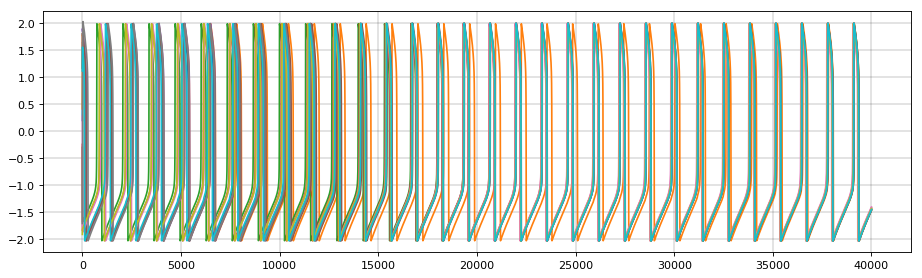

In [23]:
#@markdown ### Simulation 07
np.random.seed(0)
simD = NeuralNetwork(n_neurons=10, K=8, coupling=0.1, topology="random")
simD.simulate(iterations=40000, h=0.1)
simD.plot_pulse()